In [1]:
import sys
sys.path.append('../model_training/ventricle')

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from unet import eval_preds

from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *

from data_utils import *
from unet import dice_loss, dice_score
from models import *


#sys.path.append('../src')
#from learn_utils import *

from pathlib import Path
from torch import FloatTensor as FT

import plotly.express as px
from ipywidgets import FloatSlider, interactive

from scipy.ndimage import label

#torch.cuda.set_device(6)

#  define image paths

In [3]:
# Read images
data_path = Path("/data/public/MIM_BMETS_V6/3_final_datasets/met_number_reviewed/first_tx_1met")
trn_img = sorted(list(Path(data_path/"training/skull_stripped_1x1x3").iterdir()))
trn_mask = sorted(list(Path(data_path/"training/mets_masks_1x1x3").iterdir()))
valid_img = sorted(list(Path(data_path/"validation/skull_stripped_1x1x3").iterdir()))
valid_mask = sorted(list(Path(data_path/"validation/mets_masks_1x1x3").iterdir()))
test_img = sorted(list(Path(data_path/"testing/skull_stripped_1x1x3").iterdir()))
test_mask = sorted(list(Path(data_path/"testing/mets_masks_1x1x3").iterdir()))


print(f"Size of Train Dataset Images: {len(trn_img)} Images")
print(f"Size of Validation Dataset Images: {len(valid_img)} Images")
print(f"Size of Train Dataset Masks: {len(trn_mask)} Images")
print(f"Size of Validation Dataset Masks: {len(valid_mask)} Images")
print(f"Size of Test 1 Dataset Images: {len(test_img)} Images")
print(f"Size of Test 1 Dataset Masks: {len(test_mask)} Images")

Size of Train Dataset Images: 133 Images
Size of Validation Dataset Images: 28 Images
Size of Train Dataset Masks: 133 Images
Size of Validation Dataset Masks: 28 Images
Size of Test 1 Dataset Images: 29 Images
Size of Test 1 Dataset Masks: 29 Images


In [4]:
class MR_3D_Dataset(object):
    def __init__(self, images, ventricles, transform=None):
        self.images = images
        self.ventricles = ventricles
        self.transform = transform
    
    def __getitem__(self, index):
        image_voxel = np.load(self.images[index]).astype(np.float32)
        mask_voxel = np.load(self.ventricles[index]).astype(np.float32)
        if self.transform:
            image_voxel, mask_voxel = self.transform(image_voxel, mask_voxel)
        return FT(image_voxel[None,:]), FT(mask_voxel) 

    def __len__(self):
        return len(self.images)

train_ds = MR_3D_Dataset(trn_img, trn_mask)
valid_ds = MR_3D_Dataset(valid_img, valid_mask)   
test_ds = MR_3D_Dataset(test_img, test_mask)

bs=1
data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=1)
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size=bs), device=data.device)
valid_dl = DeviceDataLoader(DataLoader(valid_ds, batch_size=bs), device=data.device)
train_dl = DeviceDataLoader(DataLoader(train_ds, batch_size=bs), device=data.device)

# load 3D Residual UNet (b9) that was trained

In [5]:
!ls ../model_training/ventricle/models/

20191224_baseline_9.pth
20191224_mets_baseline_9.pth
best_of_20191231_Mets_first_tx_1met_simple_2.pth
best_of_20191231_Mets_first_tx_1met_simple.pth
best_of_20200101_first_tx_1met_simple_default.pth
best_of_20200102_first_tx_1met_simple_default.pth
best_of_20200113_first_tx_2mets_b9.pth
best_of_20200113_first_tx_3mets_b9.pth
best_of_20200118_first_tx_2mets_b9_2.pth
best_of_20200118_first_tx_2mets_b9.pth
best_of_20200122_first_tx_2mets_b9_2.pth
best_of_20200122_first_tx_2mets_b9_2x.pth
best_of_20200122_first_tx_2mets_b9.pth
best_of_20200124_first_tx_1met_b9.pth
best_of_20200124_first_tx_2mets_b9_2.pth
best_of_20200124_first_tx_2mets_b9.pth
best_of_20200125_first_tx_1met_b9_2.pth
best_of_20200125_first_tx_1met_b9.pth
best_of_20200126_first_tx_11+mets_b9_2.pth
best_of_20200126_first_tx_11+mets_b9.pth
best_of_20200126_first_tx_1met_b9_2.pth
best_of_20200126_first_tx_1met_b9.pth
best_of_20200126_first_tx_3mets_b9_2.pth
best_of_20200126_first_tx_3mets_b9.pth
best_of_20200126_first_tx_4-5mets

In [6]:
# Load model baseline11
model_name = 'baseline9'
f = experiment_model_dict[model_name]
m = f()
#m = VolumetricUnet(in_c=1, out_c=1, n_layers=6, c=1, block_type=conv_relu_bn_drop, kernel=3,
#                          p=0., norm_type='group', actn='prelu')
#m = VolumetricUnet(in_c=1, out_c=8, n_layers=4, c=1, block_type=conv_relu_bn_drop,
#                            norm_type='group', actn='prelu', p=0.)
    

loss_func = 'dice'
model_dir = '../model_training/ventricle/models/'
learn = Learner(data=data, model=m, callbacks=[], callback_fns=[], model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16();
#1met,best_of_20200126_first_tx_1met_b9_2
#2mets, best_of_20200124_first_tx_2mets_b9
#3mets, best_of_20200126_first_tx_3mets_b9
#4-5mets, best_of_20200126_first_tx_4-5mets_b9_2
#6-10mets, best_of_20200126_first_tx_6-10mets_b9_2
#11+mets, best_of_20200126_first_tx_11+mets_b9

learn.load('best_of_20200131_first_tx_1met_aug_B9');#'best_of_20200124_first_tx_1met_b9');


In [7]:
# get test1 predictions
learn.to_fp16();

# get test1 dice score and percent volume overlap
from tqdm import tqdm_notebook

def get_img_pred_masks(learner, dl, thresh=0.5):
    model = learner.model.eval()
    preds = []
    images = []
    masks = []
    for image, mask in tqdm_notebook(dl):
        out = model(image.half().cuda())
        out = torch.sigmoid(out).cpu().data.numpy()
        out = out.astype(float)
        out = (out > thresh)*1
        image = image.cpu().data.numpy()
        mask = mask.cpu().data.numpy()
        for i in range(out.shape[0]):
            masks.append(mask[i])
            preds.append(out[i][0])
            images.append(image[i][0])
    return images, preds, masks

def get_preds_targs(dl):
    test_preds, test_targs = get_preds(learn.model, dl)
    test_preds.squeeze_(1);
    test_preds.sigmoid_();
    return test_preds, test_targs

#test_preds, test_targs = get_preds_targs(test_dl)
#test_preds, test_masks = get_preds_targs(test_dl)#
imgs, test_preds, test_masks = get_img_pred_masks(learn, test_dl)

#print(learn.validate(test_dl))

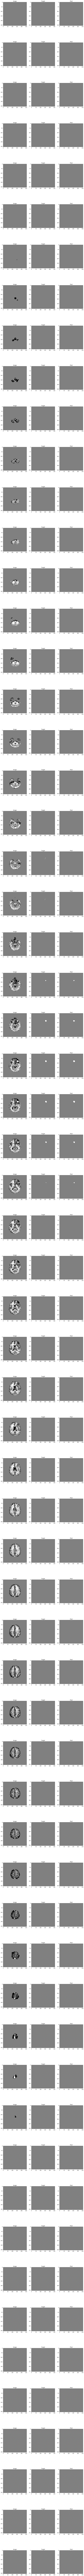

In [31]:
IMG_SET = 28
brainimgs = test_ds.__getitem__(IMG_SET)
plt.figure(figsize=(15, 500))
c = 1
for i in range(0,64):
    plt.subplot(64, 3, c)
    plt.imshow(brainimgs[0][0][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Image')
    c = c + 1
    plt.subplot(64, 3, c)
    plt.imshow(test_masks[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Target')
    c = c + 1
    plt.subplot(64, 3, c)
    plt.imshow(test_preds[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Pred')
    c = c + 1   

In [80]:
w = FloatSlider(value=32,min=0,max=63,step=1,description='Slice:')

def InteractiveReview(z):
    fig = px.imshow(t[int(z)], color_continuous_scale='gray', zmin=0, zmax=5)
    fig.update_layout(height=400, width=600)
    fig.show()

In [81]:
interactive(InteractiveReview, z=w)

interactive(children=(FloatSlider(value=32.0, description='Slice:', max=63.0, step=1.0), Output()), _dom_class…

# Generate table and figures, review testing set

In [8]:
def summary_table(target_masks, pred_masks, file_names):
    pred_dice_scores = [dice_score(pred_masks[i], target_masks[i]) for i in range(len(target_masks))]
    pred_percent_vol_diff = [vol_perc_diff(target_masks[i], pred_masks[i], True)*100 for i in range(len(target_masks))]
    TPs = [true_positive(pred_masks[i], target_masks[i]) for i in range(len(target_masks))]
    FPs = [false_positive(pred_masks[i], target_masks[i]) for i in range(len(target_masks))]
    target_mets = [label(target_masks[i]) for i in range(len(target_masks))]
    pred_mets = [label(pred_masks[i]) for i in range(len(target_masks))]
    target_num = [target_mets[i][1] for i in range(len(target_masks))] 
    pred_num = [pred_mets[i][1] for i in range(len(target_masks))] 
    d = {'test_name': file_names,
         'pred_dice_scores': pred_dice_scores, 
         'pred_percent_vol_diff': pred_percent_vol_diff,
         'target_mets': target_num,
         'pred_mets': pred_num,
         'true_positive': TPs,
         'false_positive': FPs}
    df = pd.DataFrame(data=d)
    return df

def met_volume(image,res):
    numMets = np.amax(image)# max number
    metNum, counts = np.unique(image.flatten(), return_counts=True)
    return np.asarray(counts[1:]*res)

def vol_perc_diff(mask, pred, absolute=False):
    #mask_vol = (((mask.numpy()).sum()).sum()).sum()
    #pred_vol = (((pred.numpy()).sum()).sum()).sum()
    mask_vol = ((mask.sum()).sum()).sum()
    pred_vol = ((pred.sum()).sum()).sum()
    if not absolute:
        return (pred_vol-mask_vol)/mask_vol
    return abs(pred_vol-mask_vol)/mask_vol

def dice_score(target, preds, thresh=0.5):
    iT = target#.numpy()
    iP = preds#.numpy()
    intersection = (((iT * iP).sum()).sum()).sum()
    return ((2.0 * intersection) / (((iT.sum()).sum()).sum() + ((iP.sum()).sum()).sum() + 1e-6))

# True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
def true_positive(true_labels, pred_labels):
    TP = np.logical_and(pred_labels == 1., true_labels == 1.).sum().sum().sum()
    return TP

# True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
def true_negative(true_labels, pred_labels):
    TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
    return TN

# False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
def false_positive(true_labels, pred_labels):
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
    return FP


In [9]:
names = []
data_path = data_path = Path("/data/public/MIM_BMETS_V6/3_final_datasets/met_number_reviewed/first_tx_1met")
test1_img_files = sorted(list(Path(data_path/"testing/skull_stripped_1x1x3").iterdir()))
ok_names = [o.name for o in test1_img_files]
file_names = [fn for fn in test1_img_files if fn.name in ok_names]
for i in range(len(file_names)):
    names.append(str(file_names[i]).split("/")[-1].split("_")[0])


df = summary_table(test_masks, test_preds, names)
df.describe()

,pred_dice_scores,pred_percent_vol_diff,target_mets,pred_mets,true_positive,false_positive
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.786592,21.608803,1.344828,1.034483,1482.862069,513.068966
std,0.225264,26.596416,1.494654,0.325440,1371.534327,674.126203
min,0.000000,0.579430,1.000000,0.000000,0.000000,5.000000
25%,0.753720,4.716227,1.000000,1.000000,542.000000,79.000000
50%,0.870683,11.388087,1.000000,1.000000,1135.000000,208.000000
75%,0.905575,26.855124,1.000000,1.000000,2096.000000,638.000000
max,0.957833,100.000000,9.000000,2.000000,5940.000000,2482.000000


In [10]:
# training
df[df['pred_dice_scores'] > 0.3].describe()

,pred_dice_scores,pred_percent_vol_diff,target_mets,pred_mets,true_positive,false_positive
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.840482,16.034593,1.370370,1.074074,1589.666667,413.814815
std,0.103195,17.121750,1.547905,0.266880,1361.584061,557.342322
min,0.621392,0.579430,1.000000,1.000000,64.000000,5.000000
25%,0.803258,4.409536,1.000000,1.000000,646.000000,71.500000
50%,0.876771,9.080654,1.000000,1.000000,1145.000000,173.000000
75%,0.916202,18.875826,1.000000,1.000000,2175.000000,431.000000
max,0.957833,68.421053,9.000000,2.000000,5940.000000,2224.000000


In [10]:
pd.set_option('display.max_rows', df.shape[0]+1)
df

,test_name,pred_dice_scores,pred_percent_vol_diff,target_mets,pred_mets,true_positive,false_positive
0,BrainMets-UCSF-00104,0.846043,10.005467,1,1,2940,718
1,BrainMets-UCSF-00154,0.814273,15.734757,1,1,2670,889
2,BrainMets-UCSF-00157,0.812960,31.214529,1,1,828,53
3,BrainMets-UCSF-00165,0.946911,0.096572,1,1,1962,109
4,BrainMets-UCSF-00169,0.940737,4.923414,1,1,1762,66
5,BrainMets-UCSF-00220,0.615839,0.621118,1,1,3756,2362
6,BrainMets-UCSF-00515,0.000000,169.736842,1,2,0,76
7,BrainMets-UCSF-00670,0.792975,26.943308,1,1,1174,537
8,BrainMets-UCSF-00674,0.904290,13.631022,1,2,822,29
9,BrainMets-UCSF-00726,0.881971,3.968254,1,2,340,38


In [18]:
names = []
data_path = data_path = Path("/data/public/MIM_BMETS_V6/3_final_datasets/met_number_reviewed/first_tx_1met")
test1_img_files = sorted(list(Path(data_path/"validation/skull_stripped_1x1x3").iterdir()))
ok_names = [o.name for o in test1_img_files]
file_names = [fn for fn in test1_img_files if fn.name in ok_names]
for i in range(len(file_names)):
    names.append(str(file_names[i]).split("/")[-1].split("_")[0])


df = summary_table(test_masks, test_preds, names)
df.describe()

,pred_dice_scores,pred_percent_vol_diff,target_mets,pred_mets,true_positive,false_positive
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.697529,42.557787,1.066667,1.333333,1527.533333,371.533333
std,0.253416,50.412827,0.365148,0.844182,1771.407968,531.218036
min,0.000000,0.202566,1.000000,0.000000,0.000000,0.000000
25%,0.593021,5.941715,1.000000,1.000000,334.250000,45.000000
50%,0.793593,29.072452,1.000000,1.000000,1056.000000,150.000000
75%,0.891622,56.506986,1.000000,1.750000,1883.750000,391.250000
max,0.940381,233.333333,3.000000,4.000000,7323.000000,1775.000000


In [19]:
# validation
df[df['pred_dice_scores'] < 0.5]

,test_name,pred_dice_scores,pred_percent_vol_diff,target_mets,pred_mets,true_positive,false_positive
2,BrainMets-UCSF-00300,0.371298,72.845764,1,1,326,1055
9,BrainMets-UCSF-00592,0.331910,56.291100,1,3,544,1737
13,BrainMets-UCSF-00963,0.461538,233.333333,1,1,66,0
14,BrainMets-UCSF-00981,0.000000,100.000000,1,0,0,108
15,BrainMets-UCSF-01050,0.000000,100.000000,1,0,0,55


In [9]:
names = []
data_path = data_path = Path("/data/public/MIM_BMETS_V6/3_final_datasets/met_number_reviewed/first_tx_1met")
test1_img_files = sorted(list(Path(data_path/"testing/skull_stripped_1x1x3").iterdir()))
ok_names = [o.name for o in test1_img_files]
file_names = [fn for fn in test1_img_files if fn.name in ok_names]
for i in range(len(file_names)):
    names.append(str(file_names[i]).split("/")[-1].split("_")[0])


df = summary_table(test_masks, test_preds, names)
df.describe()


,pred_dice_scores,pred_percent_vol_diff,target_mets,pred_mets,true_positive,false_positive
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.870465,21.468112,1.344828,1.137931,1904.448276,91.482759
std,0.086096,26.296600,1.494654,0.350931,1582.457054,94.954734
min,0.572650,0.876680,1.000000,1.000000,67.000000,0.000000
25%,0.863568,6.410256,1.000000,1.000000,811.000000,17.000000
50%,0.896664,10.120350,1.000000,1.000000,1421.000000,66.000000
75%,0.919903,23.728814,1.000000,1.000000,2450.000000,138.000000
max,0.971374,107.894737,9.000000,2.000000,6091.000000,326.000000


In [11]:
# testing
df[df['pred_dice_scores'] < 1]

,test_name,pred_dice_scores,pred_percent_vol_diff,target_mets,pred_mets,true_positive,false_positive
0,BrainMets-UCSF-00104,0.914410,0.902132,1,2,3360,298
1,BrainMets-UCSF-00154,0.913567,10.002810,1,1,3414,145
2,BrainMets-UCSF-00157,0.863568,27.128263,1,1,864,17
3,BrainMets-UCSF-00165,0.906692,4.925157,1,2,1924,147
4,BrainMets-UCSF-00169,0.938818,10.120350,1,1,1803,25
5,BrainMets-UCSF-00220,0.896664,11.163779,1,1,5792,326
6,BrainMets-UCSF-00515,0.572650,107.894737,1,2,67,9
7,BrainMets-UCSF-00670,0.826884,0.876680,1,1,1421,290
8,BrainMets-UCSF-00674,0.884797,23.384254,1,1,841,10
9,BrainMets-UCSF-00726,0.894089,14.814815,1,1,363,15


In [73]:
pd.set_option('display.max_rows', df.shape[0]+1)
df

,test_name,pred_dice_scores,pred_percent_vol_diff,target_mets,pred_mets,true_positive,false_positive
0,BrainMets-UCSF-00004,0.760241,30.092119,2,2,631,346
1,BrainMets-UCSF-00067,0.671292,28.166915,2,1,774,568
2,BrainMets-UCSF-00405,0.788415,12.112933,2,4,3253,1139
3,BrainMets-UCSF-00466,0.847173,16.072472,2,3,3132,290
4,BrainMets-UCSF-00487,0.865369,21.429633,2,3,6447,282
5,BrainMets-UCSF-00700,0.494890,61.536761,2,2,3099,5946
6,BrainMets-UCSF-00744,0.875627,22.346072,2,1,1834,50
7,BrainMets-UCSF-00778,0.582345,127.155172,2,9,442,22
8,BrainMets-UCSF-00822,0.651163,19.621110,2,1,434,305
9,BrainMets-UCSF-01037,0.363136,319.285714,2,4,132,8


In [74]:
indexes = df[df['pred_dice_scores']<0.25].index.tolist()
names = df['test_name'].tolist()
len(indexes)

8

/usr/local/share/anaconda3/envs/ventricle/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



<Figure size 1080x1080 with 0 Axes>

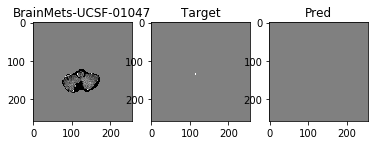

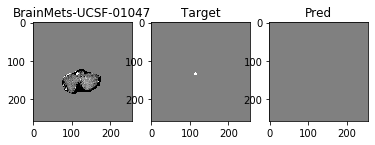

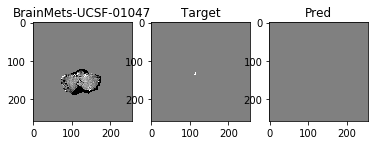

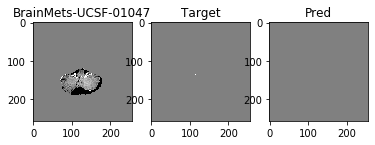

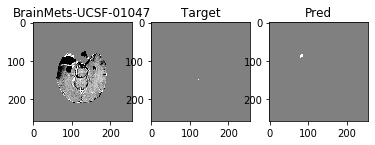

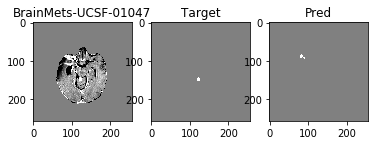

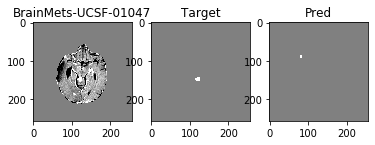

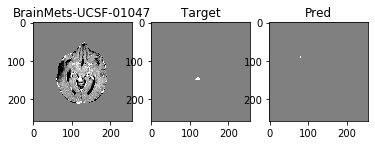

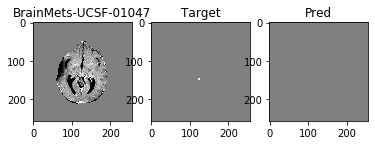

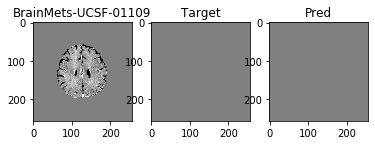

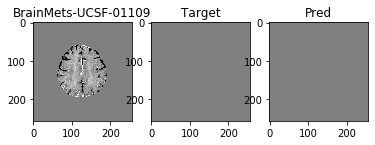

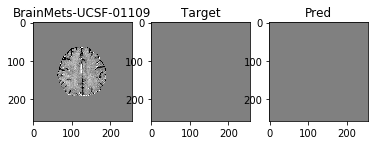

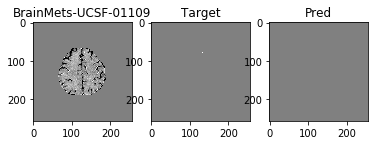

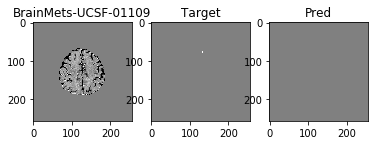

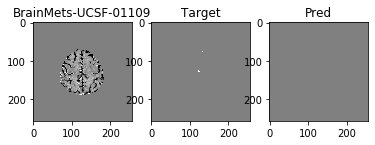

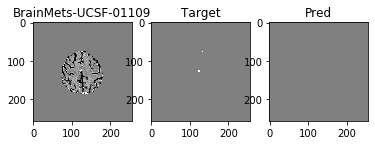

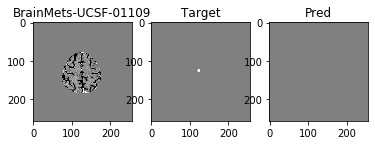

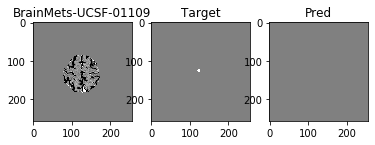

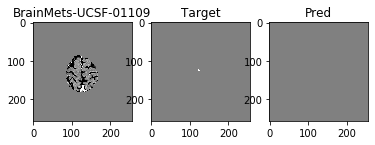

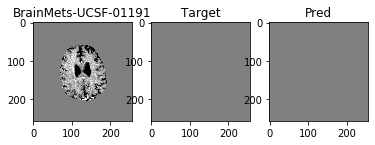

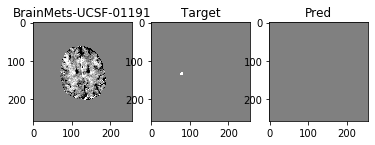

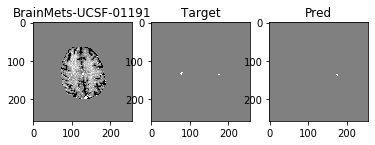

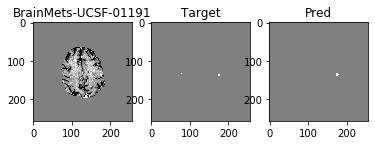

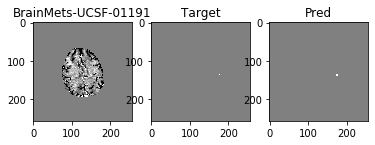

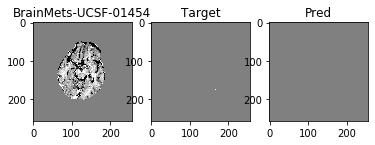

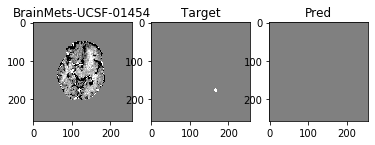

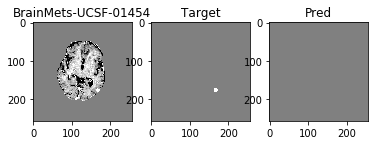

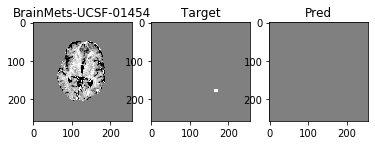

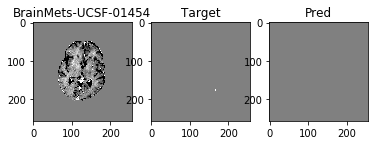

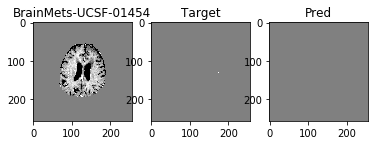

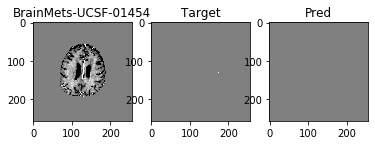

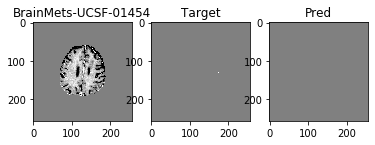

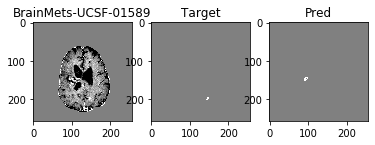

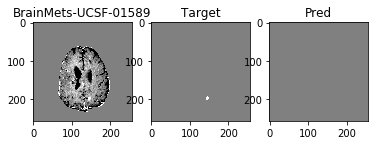

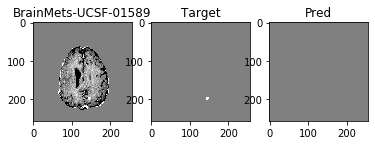

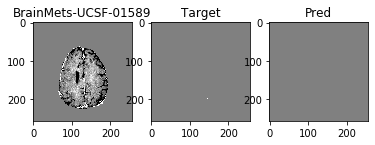

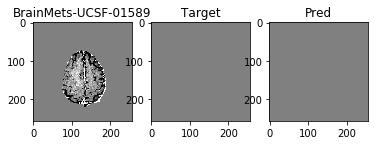

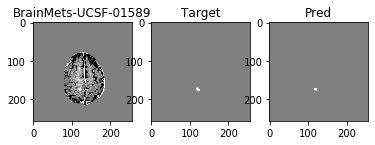

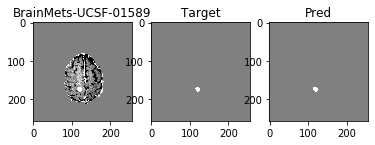

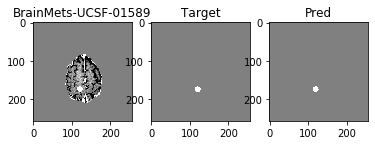

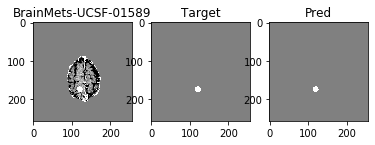

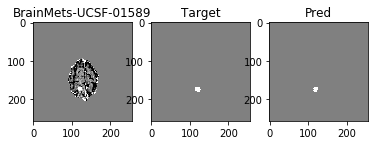

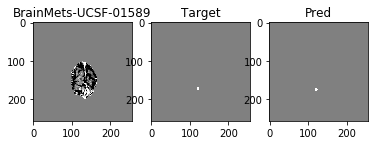

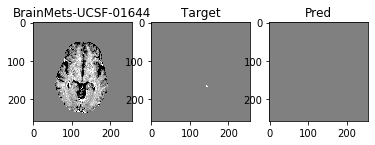

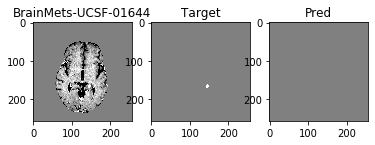

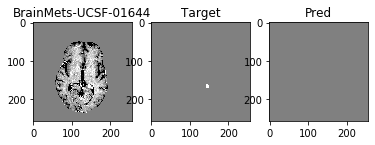

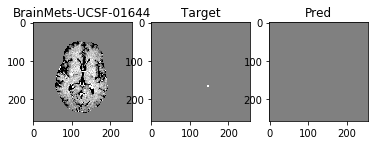

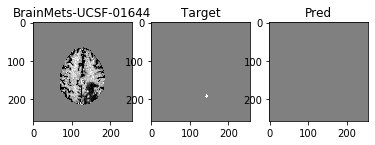

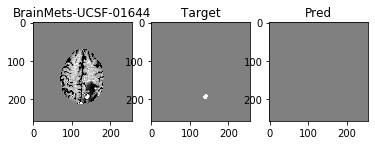

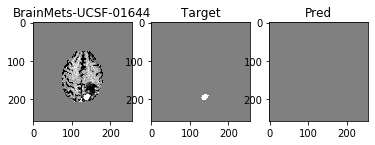

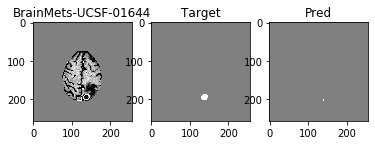

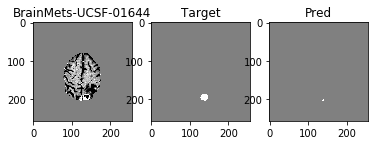

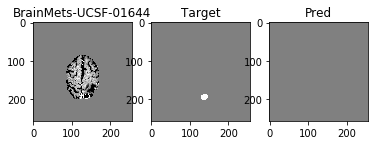

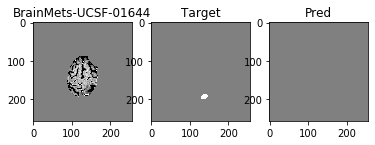

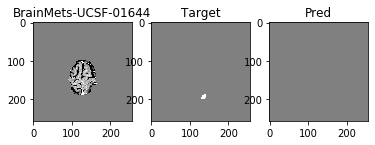

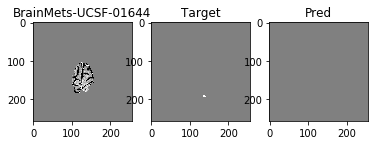

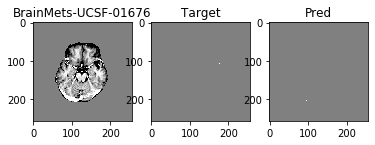

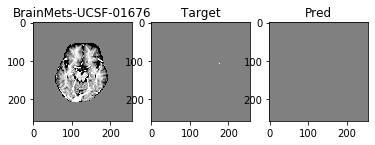

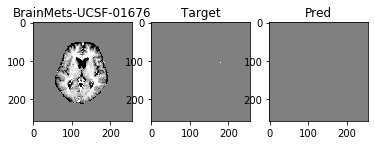

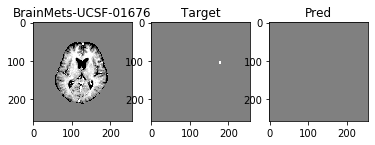

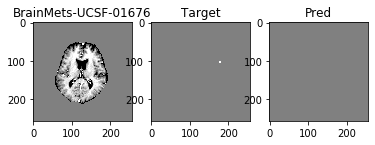

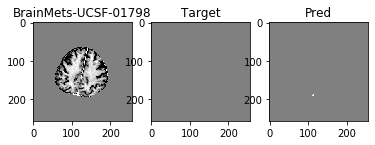

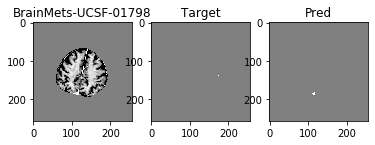

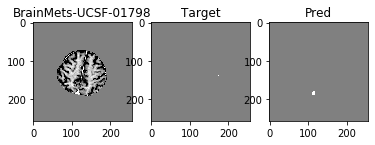

In [75]:
plt.figure(figsize=(15, 15))
c = 1
for i in indexes:
   # brainimgs = train_ds.__getitem__(i)
    for s in range(1,64):
        if sum(sum(test_masks[i][s,:,:])):
            plt.figure()
            plt.subplot(1, 3, 1)
            plt.imshow(images[i][s,:,:], cmap="gray", vmin=-1, vmax=1)
            plt.title(names[i])
            plt.subplot(1, 3, 2)
            plt.imshow(test_masks[i][s,:,:], cmap="gray", vmin=-1, vmax=1)
            plt.title('Target')
            plt.subplot(1, 3, 3)
            plt.imshow(test_preds[i][s,:,:], cmap="gray", vmin=-1, vmax=1)
            plt.title('Pred')


In [51]:
df.describe()

,pred_dice_scores,pred_percent_vol_diff,target_mets,pred_mets,true_positive,false_positive
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,0.668940,154.991878,2.394161,2.605839,1531.532847,569.386861
std,0.287673,995.986878,1.844538,2.230661,2050.973585,1277.101781
min,0.000000,0.108932,1.000000,0.000000,0.000000,0.000000
25%,0.528736,7.645099,2.000000,1.000000,199.000000,51.000000
50%,0.791390,17.664234,2.000000,2.000000,917.000000,125.000000
75%,0.871441,52.404439,2.000000,3.000000,1669.000000,448.000000
max,0.944913,11470.161290,21.000000,15.000000,13516.000000,9721.000000
